# Heart Rate推定

- 心音データのwavファイルから、心拍数を推定するプログラム
- 110bpmまではNormalモード,110bpmからはTachyモードとする
- FFTのパワーを正規化し、頻脈判定特徴量を算出
- Tachy判定をランダムフォレスト分類モデルで行う


In [2]:
# 使ってないやつもありそうなので、最終的には整理する
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.signal as signal
import scipy.stats as stats
import soundfile as sf
import joblib

from pathlib import Path
from Utils_hr_estimation import resample_waveform, spike_removal, hpf, lpf, get_sound_vol, wavelet_denoising, rms_agc_2stages, compress_peak_power,sliding_window_peak_detection, peak_interval_estimation, peak_count_estimation, detect_peaks_with_FFT


## データ読み込み

In [3]:
# データの読み込み
file_path = os.path.join('250611_hr_dataset_all.xlsx')
wav_df = pd.read_excel(file_path)

# 抽出とインデックスリセット（必要に応じて指定）
# wav_df = wav_df[wav_df['exp_study'] == 1].reset_index(drop=True)
wav_df = wav_df[wav_df['is_third_heart_sound'] != 1].reset_index(drop=True)

# WAVファイルが格納されているルートディレクトリのパス
wav_root = os.path.join('..', 'wav_dataset')

# データ数を表示
print(f"データ数: {len(wav_df)}")


データ数: 227


# process

In [4]:
### parameters ###
window_size_sec = 2 # １はNG
step_size_sec = 1
min_lag_bpm_normal = 120  # ピーク検出の最小bpm(normal)
min_lag_bpm_tachy = 220  # ピーク検出の最小bpm(tachy)
min_lag_coeff_normal = 1/(min_lag_bpm_normal/60)  # ピーク検出の最小時間(normal)
min_lag_coeff_tachy = 1/(min_lag_bpm_tachy/60)  # ピーク検出の最小時間(tachy)

fs = 1000 # 元のサンプリングレートを使う場合はsrを指定(通常1000Hz)
fc_hpf = 16.5  # HPFのカットオフ周波数
fc_lpf = 62  # LPFのカットオフ周波数
k_thr = 0.45  # ウェーブレット分解のしきい値
ma_window_size = 55  # 移動平均のウィンドウサイズ
comp_thr = 0.581  # コンプレッションのしきい値
comp_rat = 0.657  # コンプレッションの比率
prom_coeff_normal = 2.5  # ピーク検出のprominence係数(normal)
prom_coeff_tachy = 0.05  # ピーク検出のprominence係数(tachy)
height_qxx = 50  # ピーク検出のheight係数
height_coeff_normal = 1.5  # ピーク検出のheight係数(normal)
height_coeff_tachy = 0.5  # ピーク検出のheight係数(tachy)

### プロット設定 ###
plot_enable = False  # True:プロット表示, False:プロット非表示
FFT_plot_enable = False

### tachy判定モデルの読み込み ###
rf_model = joblib.load('randomforest_model_selected5_250630.pkl')
rf_imputer = joblib.load('randomforest_imputer_selected5_250630.pkl')

# 結果を格納するデータフレームを作成
all_results = []

""" for loop """
for i in range(len(wav_df)):
# for i in range(0, 2):  # テスト用
    file_name = wav_df['wav_name'][i]  # ファイル名を取得
    file_path = os.path.join(wav_root, file_name)  # wav_rootフォルダ内のファイルパスを指定
    data, sr = sf.read(file_path, dtype='int16')  # soundfileでwavファイルを読み込み

    # Filter
    data_res = resample_waveform(data, sr, fs)  # リサンプリング
    data_spike = spike_removal(data_res, window_size=5)  # スパイク除去
    data_hpf = hpf(data_spike, fs, fc_hpf)  # HPF
    data_lpf = lpf(data_hpf, fs, fc_lpf)  # LPF
    data = data_lpf
    time = np.arange(0, len(data))/fs

    # Sound Volume check
    ma_window = int(0.05 * fs +1)  # 移動平均するサンプル数（固定）
    vol_mean = get_sound_vol(data, fs, ma_window)
    wav_df.loc[i, 'sound_vol'] = vol_mean
    
    # 音量が小さい場合は以降の処理をスキップ
    if vol_mean <= 3000:
        print(f"Skipping {file_name} due to low volume (vol_mean={vol_mean:.1f})")
        continue

    ### Wavelet Denoising ###
    denoised_signal, coeffs_info = wavelet_denoising(data, wavelet='bior6.8', k_thr=k_thr, max_level=7)

    ### RMS-AGC 2-stages ###
    rms_env2_interp, rms_env2_ma = rms_agc_2stages(denoised_signal, fs,
                                  fade_sec=0.5,
                                  hop_size_sec=0.01,
                                  frame_size_sec=0.05,
                                  ma_window_size=ma_window_size,
                                  agc1_params=None,
                                  agc2_params=None)

    ### コンプレッション ###
    rms_env2_ma_comp = rms_env2_ma/(max(rms_env2_ma)+1e-8)
    rms_env2_ma_comp = compress_peak_power(rms_env2_ma_comp, threshold=comp_thr, ratio=comp_rat)

    ### 窓ごとピーク検出 ###
    peak_results = sliding_window_peak_detection(
        signal=rms_env2_ma_comp,
        fs=fs,
        window_size_sec=window_size_sec,
        step_size_sec=step_size_sec,
        min_lag_bpm_normal=min_lag_bpm_normal,
        min_lag_bpm_tachy=min_lag_bpm_tachy,
        prom_coeff_normal=prom_coeff_normal,
        prom_coeff_tachy=prom_coeff_tachy,
        height_qxx=height_qxx,
        height_coeff_normal=height_coeff_normal,
        height_coeff_tachy=height_coeff_tachy,
        plot=plot_enable
        )

    # 結果を取得
    avg_peak_count_normal = peak_results['avg_peak_count_normal']
    time_peaks_normal = peak_results['time_peaks_normal']
    avg_peak_count_tachy = peak_results['avg_peak_count_tachy']
    time_peaks_tachy = peak_results['time_peaks_tachy']


    ### ピークインターバル法で心拍数を推定 ###
    hr_interval_normal, hr_interval_tachy = peak_interval_estimation(
        avg_peak_count_normal,
        avg_peak_count_tachy,
        )

    ### ピークカウント法で心拍数を推定 ###
    hr_count_normal, hr_count_tachy = peak_count_estimation(
        time_peaks_normal,
        time_peaks_tachy,
        rms_env2_ma_comp,
        fs
        )

    ### FFTピーク検出と特徴量抽出（可視化も含む） ###
    features = detect_peaks_with_FFT(
        signal=rms_env2_interp,
        fs=fs,
        desired_sec=15,
        high_freq_thr=5.5,
        power_thr=0.3,
        prominence_coeff=0.6,
        height_threshold=0.01,
        plot=FFT_plot_enable,
        file_name=file_name,
        vol_mean=vol_mean,
        actual_hr=wav_df['heart_rate'][i]  # 実装時は削除
    )
    
    ### 特徴量を個別変数として取得 ###
    bpm_first_peak = features['bpm_first_peak']
    bpm_dominant_peak = features['bpm_dominant_peak']
    max_power_under_220 = features['max_power_under_220']
    high_freq_peaks = features['high_freq_peaks']
    bpm_spectrum_centroid = features['bpm_spectrum_centroid']
    
    # FFT特徴量辞書を作成（頻脈判定用）
    FFT_feature_dict = {
        'bpm_first_peak': bpm_first_peak,
        'bpm_dominant_peak': bpm_dominant_peak,
        'max_power_under_220': max_power_under_220,
        'high_freq_peaks': high_freq_peaks,
        'bpm_spectrum_centroid': bpm_spectrum_centroid,    }
    
    ### RandomForestによる頻脈判定 ###
    tachy_features_df = pd.DataFrame(FFT_feature_dict, index=[0])  # 特徴量をDataFrameに変換
    tachy_features_df_imputed = pd.DataFrame(rf_imputer.transform(tachy_features_df), columns=tachy_features_df.columns)  # 列名を保持したまま欠損値を補完
    tachy_flag = rf_model.predict(tachy_features_df_imputed).astype(int)  # 頻脈判定
    tachy_prob = rf_model.predict_proba(tachy_features_df_imputed)[:, 1]  # 頻脈判定確率

    ### FFT法の心拍数推定結果 ###
    # 心拍数上限を200とする。
    # normal
    hr_FFT_normal = bpm_first_peak
    if hr_FFT_normal > 200: 
        hr_FFT_normal = int(hr_FFT_normal/2)  # 200以上は2で割る
    else:
        hr_FFT_normal = int(hr_FFT_normal)
    
    # tachy
    hr_FFT_tachy = bpm_dominant_peak
    if hr_FFT_tachy > 200:  
        hr_FFT_tachy = int(hr_FFT_tachy/2)  # 200以上は2で割る
    else:
        hr_FFT_tachy = int(hr_FFT_tachy)

    ### 統合手法で心拍数を推定 ###
    hr_list_normal = [hr_interval_normal, hr_count_normal, hr_FFT_normal]  
    hr_list_tachy = [hr_interval_tachy, hr_count_tachy, hr_FFT_tachy]
    
    if tachy_flag == 0:
        hr_integrated = int(np.median(hr_list_normal))
    elif tachy_flag == 1:
        hr_integrated = hr_FFT_tachy
    else:
        hr_integrated = np.nan

    ### 各手法の結果を辞書として保存 ###
    hr = wav_df['heart_rate'][i]
    diff_interval_normal = int(hr_interval_normal - hr) if not np.isnan(hr_interval_normal) else np.nan
    diff_interval_tachy = int(hr_interval_tachy - hr) if not np.isnan(hr_interval_tachy) else np.nan
    diff_count_normal = int(hr_count_normal - hr) if not np.isnan(hr_count_normal) else np.nan
    diff_count_tachy = int(hr_count_tachy - hr) if not np.isnan(hr_count_tachy) else np.nan
    diff_FFT_normal = int(hr_FFT_normal - hr) if not np.isnan(hr_FFT_normal) else np.nan
    diff_FFT_tachy = int(hr_FFT_tachy - hr) if not np.isnan(hr_FFT_tachy) else np.nan
    diff_integrated = int(hr_integrated - hr) if not np.isnan(hr_integrated) else np.nan
    

    results_data = {
        'number': i,  # 通し番号
        'file_name': file_name,
        'note_x': wav_df['note_x'][i],
        'is_third_heart_sound': wav_df['is_third_heart_sound'][i],
        'sound_vol': vol_mean,
        'heart_rate': hr,
        'hr_interval_normal': hr_interval_normal,
        'hr_interval_tachy': hr_interval_tachy,
        'hr_count_normal': hr_count_normal,
        'hr_count_tachy': hr_count_tachy,
        'FFT_first': bpm_first_peak,
        'FFT_dominant': bpm_dominant_peak,
        'hr_FFT_normal': hr_FFT_normal,
        'hr_FFT_tachy': hr_FFT_tachy,
        'hr_integrated': hr_integrated,
        'diff_interval_normal': diff_interval_normal,
        'diff_interval_tachy': diff_interval_tachy,
        'diff_count_normal': diff_count_normal,
        'diff_count_tachy': diff_count_tachy,
        'diff_FFT_normal': diff_FFT_normal,
        'diff_FFT_tachy': diff_FFT_tachy,
        'diff_integrated': diff_integrated,
        'tachy_flag': tachy_flag,
        'tachy_prob': tachy_prob,
        }
    all_results.append(results_data)

    print(f"ファイル：{file_name} 処理完了, 心拍数：{hr}, 推定：{hr_integrated}, 誤差：{diff_integrated}, 頻脈判定：{tachy_flag}")

all_results_df = pd.DataFrame(all_results)

### データフレームを保存 ###
# resultフォルダが無い場合は作成
if not os.path.exists('result'):
    os.makedirs('result')
all_results_df.to_csv('result/hr_final_250625.csv', index=False)
all_results_df.to_pickle('result/hr_final_250625.pkl')
print("結果を保存しました。")


ファイル：3002_20240114070258_163.wav 処理完了, 心拍数：84, 推定：84, 誤差：0, 頻脈判定：[0]
ファイル：1003_20240126081339_365.wav 処理完了, 心拍数：96, 推定：96, 誤差：0, 頻脈判定：[0]
ファイル：1003_20240126180226_375.wav 処理完了, 心拍数：92, 推定：94, 誤差：2, 頻脈判定：[0]
ファイル：1004_20240202132845_632.wav 処理完了, 心拍数：76, 推定：74, 誤差：-2, 頻脈判定：[0]
ファイル：3005_20240202143120_634.wav 処理完了, 心拍数：80, 推定：76, 誤差：-4, 頻脈判定：[0]
ファイル：1004_20240206190416_832.wav 処理完了, 心拍数：84, 推定：78, 誤差：-6, 頻脈判定：[0]
ファイル：1004_20240208083659_892.wav 処理完了, 心拍数：76, 推定：73, 誤差：-3, 頻脈判定：[0]
ファイル：4002_20240209174433_964.wav 処理完了, 心拍数：64, 推定：60, 誤差：-4, 頻脈判定：[0]
Skipping 4002_20240210184148_1024.wav due to low volume (vol_mean=2984.0)
ファイル：1005_20240212073036_1090.wav 処理完了, 心拍数：64, 推定：68, 誤差：4, 頻脈判定：[0]
ファイル：3009_20240228134341_1967.wav 処理完了, 心拍数：56, 推定：60, 誤差：4, 頻脈判定：[0]
ファイル：3006_20240229070350_1990.wav 処理完了, 心拍数：80, 推定：60, 誤差：-20, 頻脈判定：[0]
ファイル：1005_20240301114632_2134.wav 処理完了, 心拍数：68, 推定：76, 誤差：8, 頻脈判定：[0]
ファイル：3009_20240301115220_2135.wav 処理完了, 心拍数：60, 推定：64, 誤差：4, 頻脈判定：[0]
ファイル：1008_2024032

# 結果プロット

## データ抽出

In [5]:
# all_results_dfのsound_volの閾値を設定
sound_vol_thr = 3000
plot_df = all_results_df[all_results_df['sound_vol'] > sound_vol_thr]

# データ数を表示
print(f"データ数: {len(plot_df)}")
print(f"normal: {len(plot_df[plot_df['tachy_flag']==0])}")
print(f"tachy_flag: {len(plot_df[plot_df['tachy_flag']==1])}")


データ数: 204
normal: 160
tachy_flag: 44


## 散布図 - 各手法の各モード


=== Error Statistics for Envelope ===
Mean Absolute Error: 3.31 bpm
Root Mean Square Error: 5.91 bpm

=== Detailed Statistics for Error (Estimated - Actual) ===
 count      Mean      Std  Min  25%  50%  75%  Max
   204 -0.156863 5.911513  -29 -2.0  0.0  2.0   28


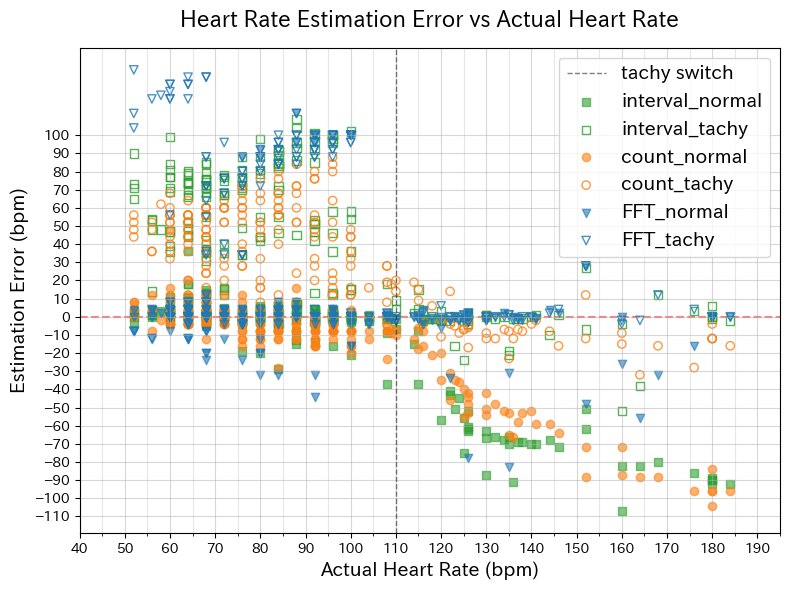

In [6]:
# オブジェクト指向インターフェースでグラフを作成
fig, ax = plt.subplots(figsize=(8, 6))

# ゼロラインを追加
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, zorder=0)

# tachy切り替えラインを追加
ax.axvline(x=110, color='k', linestyle='--', alpha=0.5, linewidth=1, label='tachy switch')

# インターバル法をプロット
ax.scatter(plot_df['heart_rate'], plot_df['diff_interval_normal'],
          c='#2ca02c', marker='s', label='interval_normal', alpha=0.6)
ax.scatter(plot_df['heart_rate'], plot_df['diff_interval_tachy'],
          marker='s', label='interval_tachy', alpha=0.8, edgecolors='#2ca02c', facecolors='none')

# カウント法をプロット
ax.scatter(plot_df['heart_rate'], plot_df['diff_count_normal'],
          c='#ff7f0e', marker='o', label='count_normal', alpha=0.6)
ax.scatter(plot_df['heart_rate'], plot_df['diff_count_tachy'],
          marker='o', label='count_tachy', alpha=0.8, edgecolors='#ff7f0e', facecolors='none')

# FFT法をプロット
ax.scatter(plot_df['heart_rate'], plot_df['diff_FFT_normal'],
          c='#1f77b4', marker='v', label='FFT_normal', alpha=0.6)
ax.scatter(plot_df['heart_rate'], plot_df['diff_FFT_tachy'],
          marker='v', label='FFT_tachy', alpha=0.8, edgecolors='#1f77b4', facecolors='none')

ax.set_title('Heart Rate Estimation Error vs Actual Heart Rate', fontsize=16, pad=15)
ax.set_xlabel('Actual Heart Rate (bpm)', fontsize=14)
ax.set_ylabel('Estimation Error (bpm)', fontsize=14)

x_major_ticks = np.arange(40, 200, 10)
x_minor_ticks = np.arange(40, 200, 5)
y_major_ticks = np.arange(-110, 110, 10)
y_minor_ticks = np.arange(-110, 110, 10)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)

ax.legend(fontsize=14)

# 統計情報を計算
error = plot_df['hr_integrated'] - plot_df['heart_rate']
error = error[~np.isnan(error)]  # NaNを除外

mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error**2))
print("\n=== Error Statistics for Envelope ===")
print(f"Mean Absolute Error: {mae:.2f} bpm")
print(f"Root Mean Square Error: {rmse:.2f} bpm")

# 統計情報をデータフレームとして整理
stats_dict = {
    'count': [len(error)],
    'Mean': [np.mean(error)],
    'Std': [np.std(error)], 
    'Min': [np.min(error)],
    '25%': [np.percentile(error, 25)],
    '50%': [np.median(error)],
    '75%': [np.percentile(error, 75)],
    'Max': [np.max(error)]
}
stats_df = pd.DataFrame(stats_dict)
print("\n=== Detailed Statistics for Error (Estimated - Actual) ===")
print(stats_df.to_string(index=False))

plt.tight_layout()
plt.show()

# 統計情報を保存
stats_df.to_csv('result/all_result_df_stats.csv', index=False)


## 散布図 - 統合手法


=== Error Statistics for Envelope ===
Mean Absolute Error: 3.31 bpm
Root Mean Square Error: 5.91 bpm

=== Detailed Statistics for Error (Estimated - Actual) ===
 count      Mean      Std  Min  25%  50%  75%  Max
   204 -0.156863 5.911513  -29 -2.0  0.0  2.0   28


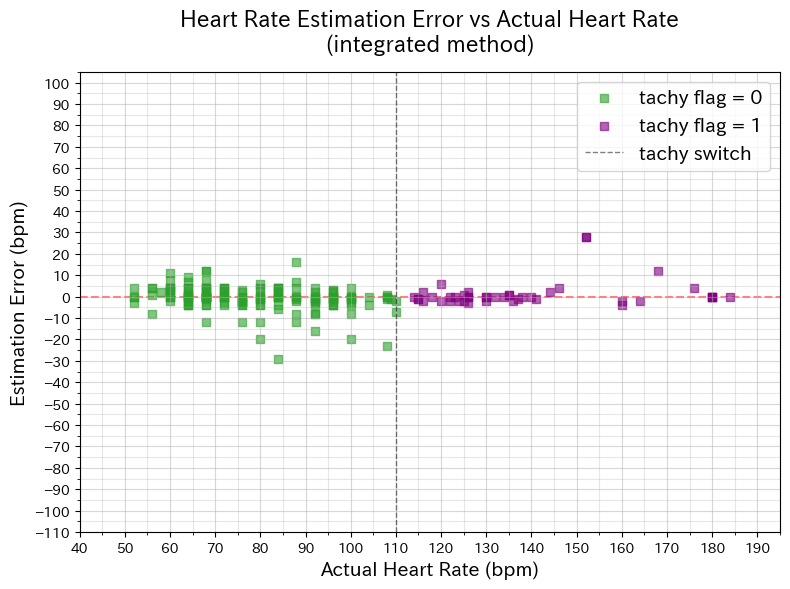

In [7]:
# オブジェクト指向インターフェースでグラフを作成
fig, ax = plt.subplots(figsize=(8, 6))

# 散布図をプロット
ax.scatter(plot_df[plot_df['tachy_flag']==0]['heart_rate'], 
          plot_df[plot_df['tachy_flag']==0]['diff_integrated'],
          c='#2ca02c',  # 緑色
          marker='s',    # 四角形のマーカー
          label='tachy flag = 0',
          alpha=0.6)

# 頻脈データを別のscatterでプロット
ax.scatter(plot_df[plot_df['tachy_flag']==1]['heart_rate'],
          plot_df[plot_df['tachy_flag']==1]['diff_integrated'],
          c='purple',  # 紫色
          marker='s',    # 四角形のマーカー
          label='tachy flag = 1',
          alpha=0.6)

# # 実際の値を水平線上にプロット
# actual_values = plot_df['heart_rate']
# ax.scatter(actual_values, np.zeros_like(actual_values),
#           c='red', marker='*', s=100, 
#           label='Actual Values', alpha=0.5,
#           zorder=5)

# ゼロラインを追加
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, zorder=0)
# tachy切り替えラインを追加
ax.axvline(x=110, color='k', linestyle='--', alpha=0.5, linewidth=1, label='tachy switch')

ax.set_title('Heart Rate Estimation Error vs Actual Heart Rate\n(integrated method)', fontsize=16, pad=15)
ax.set_xlabel('Actual Heart Rate (bpm)', fontsize=14)
ax.set_ylabel('Estimation Error (bpm)', fontsize=14)

x_major_ticks = np.arange(40, 200, 10)
x_minor_ticks = np.arange(40, 200, 5)
y_major_ticks = np.arange(-110, 110, 10)
y_minor_ticks = np.arange(-110, 110, 5)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)

ax.legend(fontsize=14)

# 統計情報を計算
error = plot_df['hr_integrated'] - plot_df['heart_rate']
error = error[~np.isnan(error)]  # NaNを除外

mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error**2))
print("\n=== Error Statistics for Envelope ===")
print(f"Mean Absolute Error: {mae:.2f} bpm")
print(f"Root Mean Square Error: {rmse:.2f} bpm")

# 統計情報をデータフレームとして整理
stats_dict = {
    'count': [len(error)],
    'Mean': [np.mean(error)],
    'Std': [np.std(error)], 
    'Min': [np.min(error)],
    '25%': [np.percentile(error, 25)],
    '50%': [np.median(error)],
    '75%': [np.percentile(error, 75)],
    'Max': [np.max(error)]
}
stats_df = pd.DataFrame(stats_dict)
print("\n=== Detailed Statistics for Error (Estimated - Actual) ===")
print(stats_df.to_string(index=False))

plt.tight_layout()
plt.show()



## 散布図 - 統合手法（割合）


=== Error Statistics for Envelope ===
Mean Absolute Error: 3.92 %
Root Mean Square Error: 6.65 %

=== Detailed Statistics for Error (Estimated - Actual) ===
 count      Mean      Std       Min       25%  50%      75%       Max
   204 -0.109239 6.648359 -34.52381 -1.646175  0.0 2.198617 18.421053


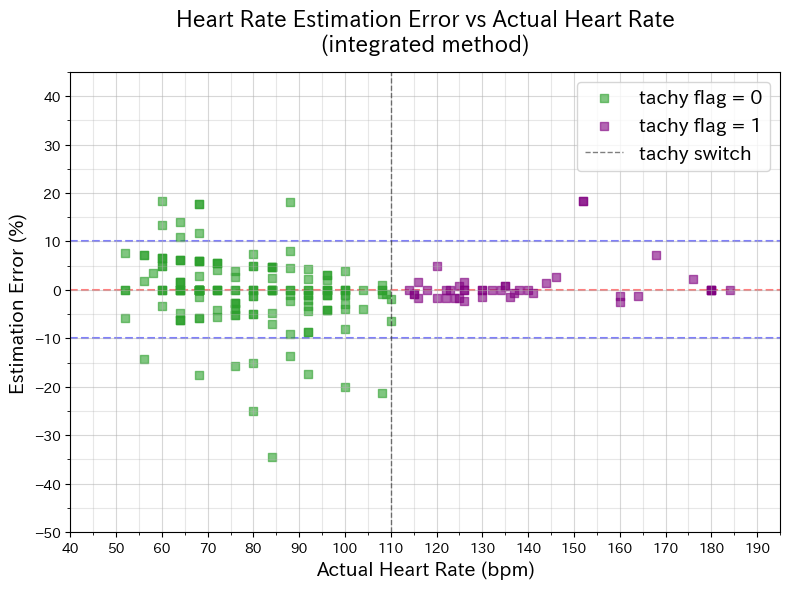

In [8]:
# 誤差の割合をプロット
# オブジェクト指向インターフェースでグラフを作成
fig, ax = plt.subplots(figsize=(8, 6))

# 散布図をプロット
ax.scatter(plot_df[plot_df['tachy_flag']==0]['heart_rate'], 
          (plot_df[plot_df['tachy_flag']==0]['diff_integrated']/plot_df[plot_df['tachy_flag']==0]['heart_rate'])*100,
          c='#2ca02c',  # 緑色
          marker='s',    # 四角形のマーカー
          label='tachy flag = 0',
          alpha=0.6)

# 頻脈データを別のscatterでプロット
ax.scatter(plot_df[plot_df['tachy_flag']==1]['heart_rate'],
          (plot_df[plot_df['tachy_flag']==1]['diff_integrated']/plot_df[plot_df['tachy_flag']==1]['heart_rate'])*100,
          c='purple',  # 紫色
          marker='s',    # 四角形のマーカー
          label='tachy flag = 1',
          alpha=0.6)

# # 実際の値を水平線上にプロット
# actual_values = plot_df['heart_rate']
# ax.scatter(actual_values, np.zeros_like(actual_values),
#           c='red', marker='*', s=100, 
#           label='Actual Values', alpha=0.5,
#           zorder=5)

# ゼロラインを追加
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, zorder=0)
# 10%のラインを追加
ax.axhline(y=10, color='b', linestyle='--', alpha=0.5, zorder=0)
ax.axhline(y=-10, color='b', linestyle='--', alpha=0.5, zorder=0)

# tachy切り替えラインを追加
ax.axvline(x=110, color='k', linestyle='--', alpha=0.5, linewidth=1, label='tachy switch')

ax.set_title('Heart Rate Estimation Error vs Actual Heart Rate\n(integrated method)', fontsize=16, pad=15)
ax.set_xlabel('Actual Heart Rate (bpm)', fontsize=14)
ax.set_ylabel('Estimation Error (%)', fontsize=14)

x_major_ticks = np.arange(40, 200, 10)
x_minor_ticks = np.arange(40, 200, 5)
y_major_ticks = np.arange(-50, 50, 10)
y_minor_ticks = np.arange(-50, 50, 5)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)

ax.legend(fontsize=14)

# 統計情報を計算
error = (plot_df['hr_integrated'] / plot_df['heart_rate'] * 100) - 100
error = error[~np.isnan(error)]  # NaNを除外

mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error**2))
print("\n=== Error Statistics for Envelope ===")
print(f"Mean Absolute Error: {mae:.2f} %")
print(f"Root Mean Square Error: {rmse:.2f} %")

# 統計情報をデータフレームとして整理
stats_dict = {
    'count': [len(error)],
    'Mean': [np.mean(error)],
    'Std': [np.std(error)], 
    'Min': [np.min(error)],
    '25%': [np.percentile(error, 25)],
    '50%': [np.median(error)],
    '75%': [np.percentile(error, 75)],
    'Max': [np.max(error)]
}
stats_df = pd.DataFrame(stats_dict)
print("\n=== Detailed Statistics for Error (Estimated - Actual) ===")
print(stats_df.to_string(index=False))

plt.tight_layout()
plt.show()



## 誤差ヒストグラム - 統合手法

/var/folders/y7/zcmknqt500j2hmmg4wbqp2xh0000gn/T/ipykernel_42137/3585669092.py:20: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.histplot(data=plot_data, x='value', hue='type', ax=ax,


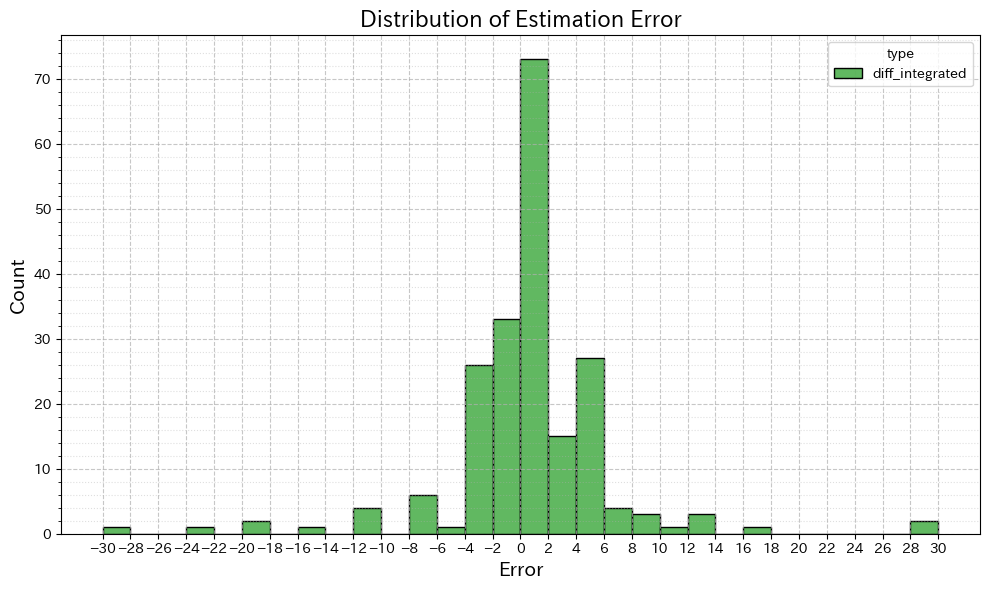

誤差の標準偏差(integrated): 5.93

平均絶対誤差(integrated): 3.31

RMSE(integrated): 5.91

誤差の範囲(integrated): 57.00


In [9]:
import seaborn as sns
import matplotlib.ticker as ticker

# 誤差のヒストグラム
# フィギュアとサブプロットの作成
fig, ax = plt.subplots(figsize=(10, 6))

# データを長い形式に変換
plot_data = pd.DataFrame({
    'value': pd.concat([plot_df['diff_integrated']]),
    'type': ['diff_integrated'] * len(plot_df)
})

# ビンの範囲と幅を設定
bin_min = plot_data['value'].min() - (plot_data['value'].min() % 5)
bin_max = plot_data['value'].max() + (5 - plot_data['value'].max() % 5)
bin_width = 2

# 並べて表示するヒストグラムの作成
sns.histplot(data=plot_data, x='value', hue='type', ax=ax,
            binwidth=bin_width,
            binrange=(bin_min, bin_max),
            multiple='dodge',  # バーを並べて表示
            palette=['#2ca02c', '#ff7f0e', '#1f77b4'])

# x軸の目盛りを5単位で設定
ax.set_xticks(np.arange(bin_min, bin_max + bin_width, bin_width))

# グリッドの設定
ax.grid(True, linestyle='--', alpha=0.7)  # メジャーグリッド
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))  # マイナーグリッドを2単位で設定
ax.grid(True, which='minor', linestyle=':', alpha=0.4)  # マイナーグリッドのスタイル設定

ax.set_title('Distribution of Estimation Error', fontsize=16)
ax.set_xlabel('Error', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()


# ばらつき評価
# 標準偏差の計算
std_error_integrated = plot_df['diff_integrated'].std()
print(f"誤差の標準偏差(integrated): {std_error_integrated:.2f}")

# 平均絶対誤差の計算
mae_integrated = plot_df['diff_integrated'].abs().mean()
print(f"\n平均絶対誤差(integrated): {mae_integrated:.2f}")

# RMSEの計算
rmse_integrated = np.sqrt(np.mean(plot_df['diff_integrated']**2))
print(f"\nRMSE(integrated): {rmse_integrated:.2f}")

# 誤差の範囲
error_range_integrated = plot_df['diff_integrated'].max() - plot_df['diff_integrated'].min()
print(f"\n誤差の範囲(integrated): {error_range_integrated:.2f}")


## 誤差ヒストグラム - 統合手法（誤差率）

/var/folders/y7/zcmknqt500j2hmmg4wbqp2xh0000gn/T/ipykernel_42137/575881490.py:20: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.histplot(data=plot_data, x='value', hue='type', ax=ax,


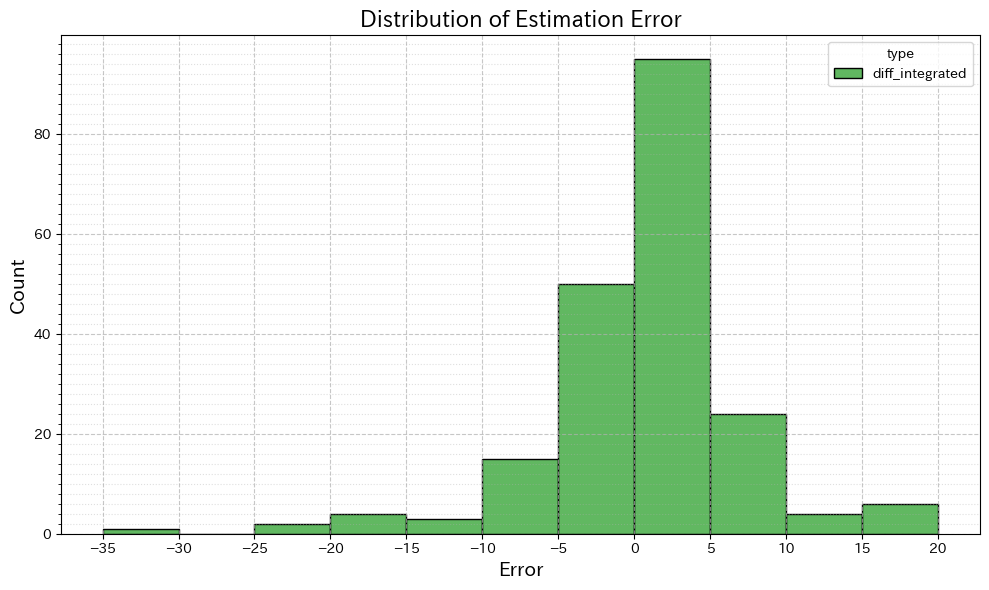

誤差の標準偏差(integrated): 5.93

平均絶対誤差(integrated): 3.31

RMSE(integrated): 5.91

誤差の範囲(integrated): 57.00


In [10]:
import seaborn as sns
import matplotlib.ticker as ticker

# 誤差のヒストグラム
# フィギュアとサブプロットの作成
fig, ax = plt.subplots(figsize=(10, 6))

# データを長い形式に変換
plot_data = pd.DataFrame({
    'value': pd.concat([plot_df['diff_integrated']/plot_df['heart_rate']*100]),
    'type': ['diff_integrated'] * len(plot_df)
})

# ビンの範囲と幅を設定
bin_min = plot_data['value'].min() - (plot_data['value'].min() % 5)
bin_max = plot_data['value'].max() + (5 - plot_data['value'].max() % 5)
bin_width = 5

# 並べて表示するヒストグラムの作成
sns.histplot(data=plot_data, x='value', hue='type', ax=ax,
            binwidth=bin_width,
            binrange=(bin_min, bin_max),
            multiple='dodge',  # バーを並べて表示
            palette=['#2ca02c', '#ff7f0e', '#1f77b4'])

# x軸の目盛りを5単位で設定
ax.set_xticks(np.arange(bin_min, bin_max + bin_width, bin_width))

# グリッドの設定
ax.grid(True, linestyle='--', alpha=0.7)  # メジャーグリッド
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))  # マイナーグリッドを2単位で設定
ax.grid(True, which='minor', linestyle=':', alpha=0.4)  # マイナーグリッドのスタイル設定

ax.set_title('Distribution of Estimation Error', fontsize=16)
ax.set_xlabel('Error', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()


# ばらつき評価
# 標準偏差の計算
std_error_integrated = plot_df['diff_integrated'].std()
print(f"誤差の標準偏差(integrated): {std_error_integrated:.2f}")

# 平均絶対誤差の計算
mae_integrated = plot_df['diff_integrated'].abs().mean()
print(f"\n平均絶対誤差(integrated): {mae_integrated:.2f}")

# RMSEの計算
rmse_integrated = np.sqrt(np.mean(plot_df['diff_integrated']**2))
print(f"\nRMSE(integrated): {rmse_integrated:.2f}")

# 誤差の範囲
error_range_integrated = plot_df['diff_integrated'].max() - plot_df['diff_integrated'].min()
print(f"\n誤差の範囲(integrated): {error_range_integrated:.2f}")


## データチェック

プロット点数: 204
誤差の小さいデータ数: 188
誤差の大きいデータ数: 0
誤差が±5以下の割合: 92.16%


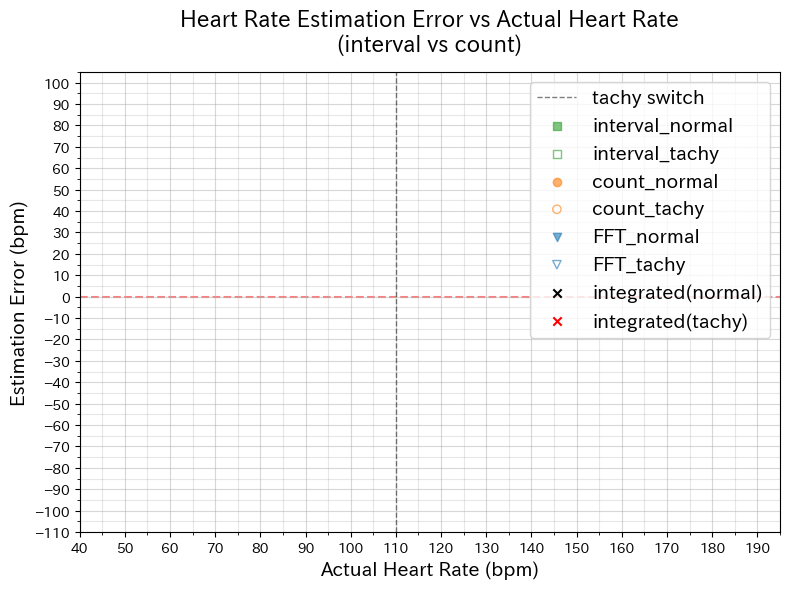

In [11]:
# 誤差でのデータ抽出
small_error_df = plot_df[abs(plot_df['diff_integrated']) <= 10].reset_index(drop=True)  # 誤差の絶対値が指定値以下
large_error_df = plot_df[abs(plot_df['diff_integrated']) > 30].reset_index(drop=True)  # 誤差の絶対値が指定値以上
# large_error_df = plot_df[plot_df['diff_integrated'] < -15].reset_index(drop=True)  # 誤差が指定値以下
# large_error_df = plot_df[abs(plot_df['diff_FFT']) > 30].reset_index(drop=True)  # 誤差の絶対値が指定値以上
print(f"プロット点数: {len(plot_df)}")
print(f"誤差の小さいデータ数: {len(small_error_df)}")
print(f"誤差の大きいデータ数: {len(large_error_df)}")
print(f"誤差が±5以下の割合: {len(small_error_df)/len(plot_df)*100:.2f}%")

# 誤差の散布図プロット
# オブジェクト指向インターフェースでグラフを作成
fig, ax = plt.subplots(figsize=(8, 6))

# ゼロラインを追加
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, zorder=0)

# tachy切り替えラインを追加
ax.axvline(x=110, color='k', linestyle='--', alpha=0.5, linewidth=1, label='tachy switch')

# インターバル法をプロット
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_interval_normal'],
          c='#2ca02c', marker='s', label='interval_normal', alpha=0.6)
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_interval_tachy'],
          marker='s', label='interval_tachy', alpha=0.6, edgecolors='#2ca02c', facecolors='none')

# カウント法をプロット
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_count_normal'],
          c='#ff7f0e', marker='o', label='count_normal', alpha=0.6)
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_count_tachy'],
          marker='o', label='count_tachy', alpha=0.6, edgecolors='#ff7f0e', facecolors='none')

# FFT法をプロット
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_FFT_normal'],
          c='#1f77b4', marker='v', label='FFT_normal', alpha=0.6)
ax.scatter(large_error_df['heart_rate'], large_error_df['diff_FFT_tachy'],
          marker='v', label='FFT_tachy', alpha=0.6, edgecolors='#1f77b4', facecolors='none')

# 統合手法をプロット
ax.scatter(large_error_df['heart_rate'][large_error_df['tachy_flag']==0], large_error_df['diff_integrated'][large_error_df['tachy_flag']==0],
          marker='x', label='integrated(normal)', alpha=1, c='k')
ax.scatter(large_error_df['heart_rate'][large_error_df['tachy_flag']==1], large_error_df['diff_integrated'][large_error_df['tachy_flag']==1],
          marker='x', label='integrated(tachy)', alpha=1, c='red')

ax.set_title('Heart Rate Estimation Error vs Actual Heart Rate\n(interval vs count)', fontsize=16, pad=15)
ax.set_xlabel('Actual Heart Rate (bpm)', fontsize=14)
ax.set_ylabel('Estimation Error (bpm)', fontsize=14)

x_major_ticks = np.arange(40, 200, 10)
x_minor_ticks = np.arange(40, 200, 5)
y_major_ticks = np.arange(-110, 110, 10)
y_minor_ticks = np.arange(-110, 110, 5)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.5)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()
# 


## 波形確認